# Inputs

In [1]:
import os
import re

folder_name = '327/Pulse Calibration Redo'
file_names = [file_name for file_name in os.listdir(folder_name) if re.match(r'^\d+_\d+\.csv$', file_name)]

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
# %matplotlib widget

In [3]:
# Fit a decaying exponential to the envelope (no need for peak detection here)
# Model: A * exp(-t / T2star*) + C
def model_exp(t, A, T2star, C):
    return A * np.exp(-t / T2star) + C

# Load data

In [4]:
# Read the data and pulse times from filenames
data = []
pulse_times = []
for file_name in file_names:
    # Assumes the file name format has the pulse time (in us) before 'us'
    pulse_time = int(file_name.split('/')[-1].split('_')[0])
    df = pd.read_csv(os.path.join(folder_name, file_name), header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    df = df[(df['t'] > 0.001) & (df['t'] < 0.004)]
    # df = df[(df['t'] > 0.001)]
    data.append(df)
    pulse_times.append(pulse_time)

# Use sum of squares to reconstruct envelope, and fit envelope

Covariance matrix for pulse time 40:
Fit parameter names: A, T2star, f, phi, C_real, C_imag
[[9.533e-03 -2.608e-07 1.942e-05 2.788e-10 1.237e-05 1.032e-05]
 [-2.608e-07 7.617e-12 8.269e-13 -4.851e-12 -2.696e-10 -2.463e-10]
 [1.942e-05 8.269e-13 7.589e-01 -6.470e-03 7.773e-05 -8.511e-05]
 [2.788e-10 -4.851e-12 -6.470e-03 5.889e-05 -8.112e-07 9.722e-07]
 [1.237e-05 -2.696e-10 7.773e-05 -8.112e-07 4.273e-06 2.377e-15]
 [1.032e-05 -2.463e-10 -8.511e-05 9.722e-07 2.377e-15 4.273e-06]]
Correlation coefficients:
[[1.000e+00 -1.000e+00 -1.965e-01 1.964e-01 -4.976e-02 2.949e-01]
 [-1.000e+00 1.000e+00 1.984e-01 -1.983e-01 5.167e-02 -2.968e-01]
 [-1.965e-01 1.984e-01 1.000e+00 -1.000e+00 9.876e-01 -9.938e-01]
 [1.964e-01 -1.983e-01 -1.000e+00 1.000e+00 -9.877e-01 9.938e-01]
 [-4.976e-02 5.167e-02 9.876e-01 -9.877e-01 1.000e+00 -9.674e-01]
 [2.949e-01 -2.968e-01 -9.938e-01 9.938e-01 -9.674e-01 1.000e+00]]
Covariance matrix for pulse time 42:
Fit parameter names: A, T2star, f, phi, C_real, C_imag


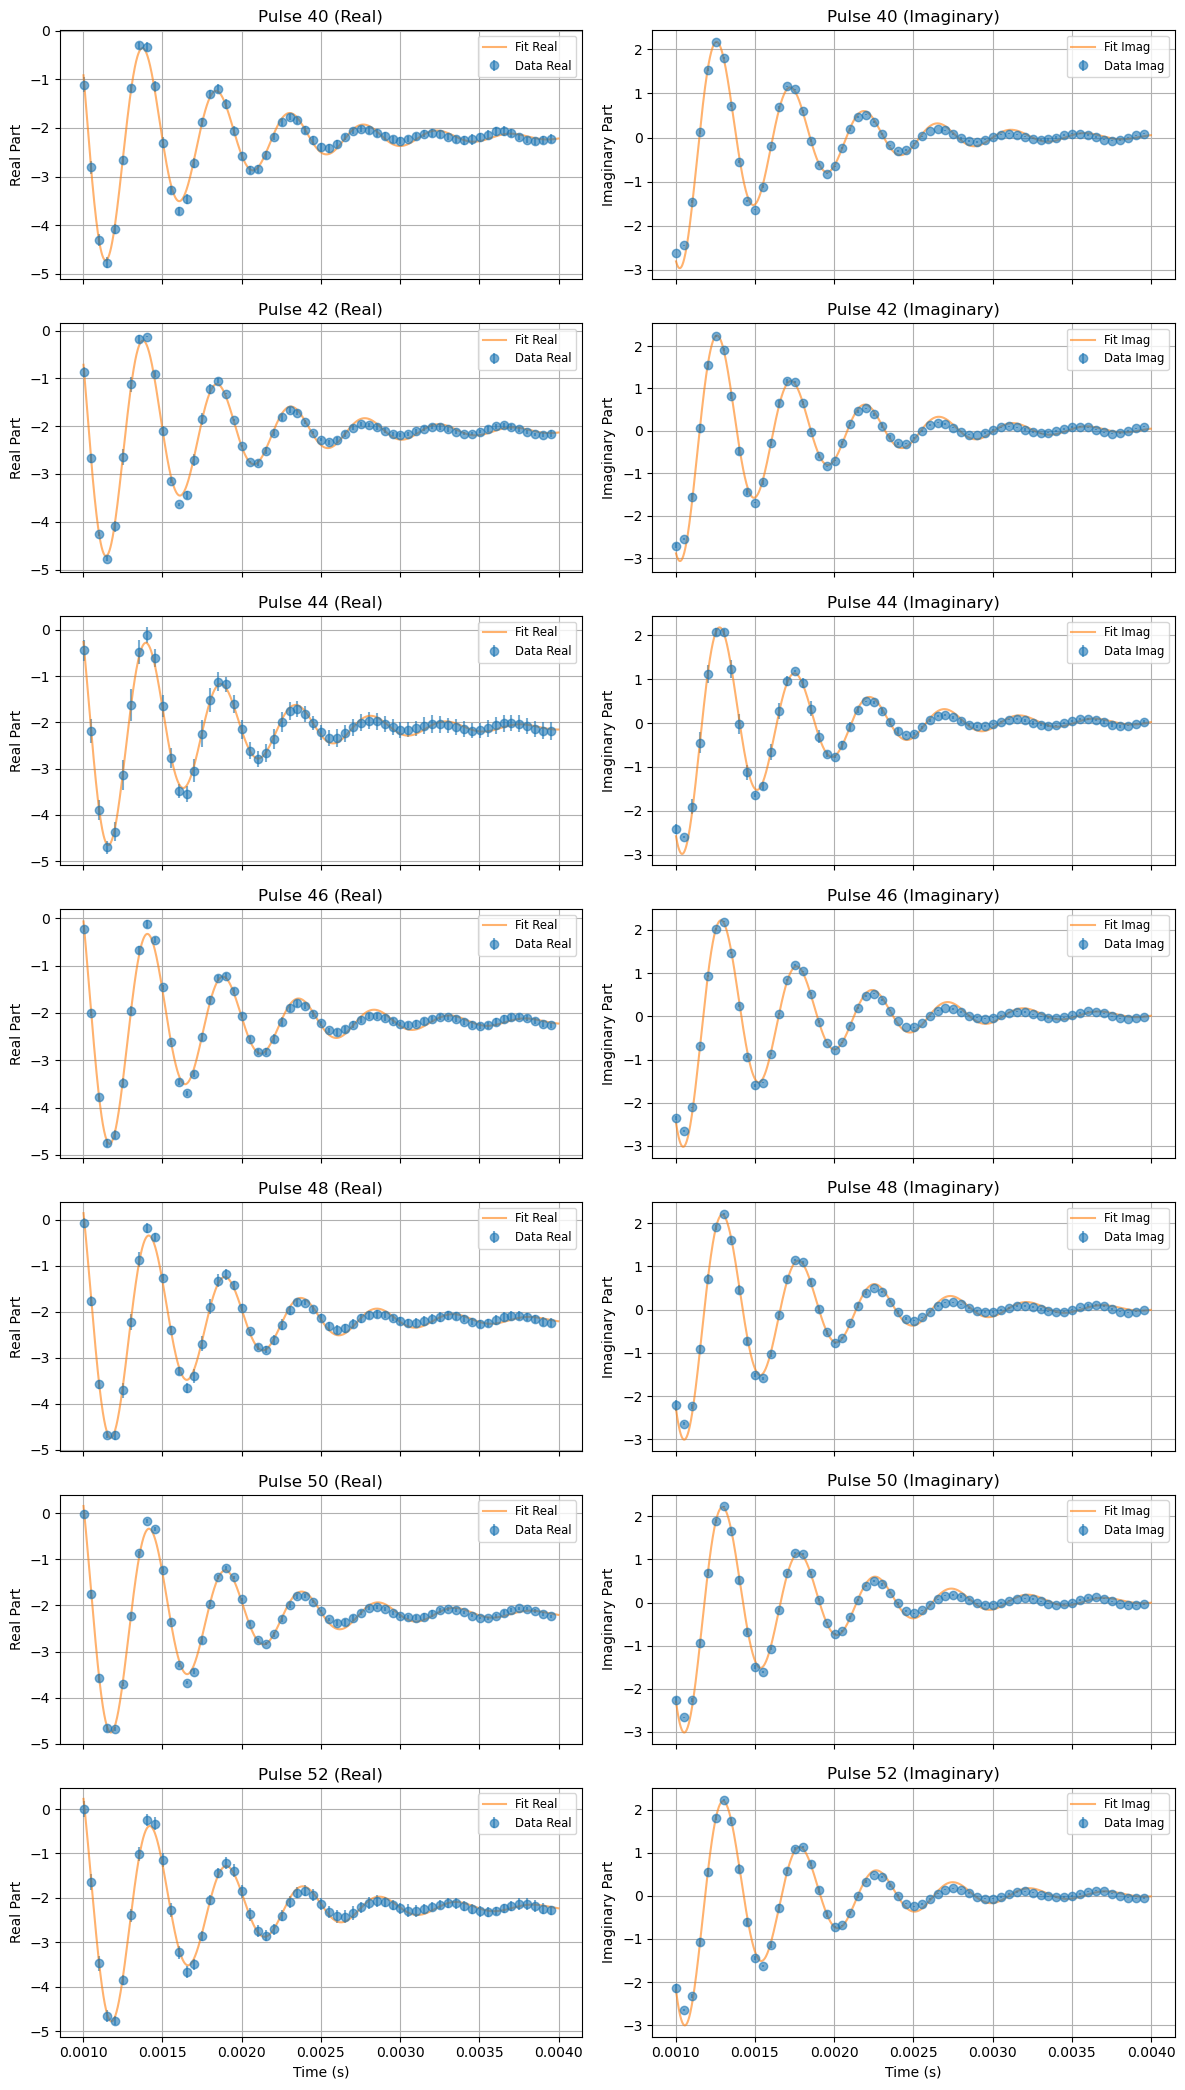

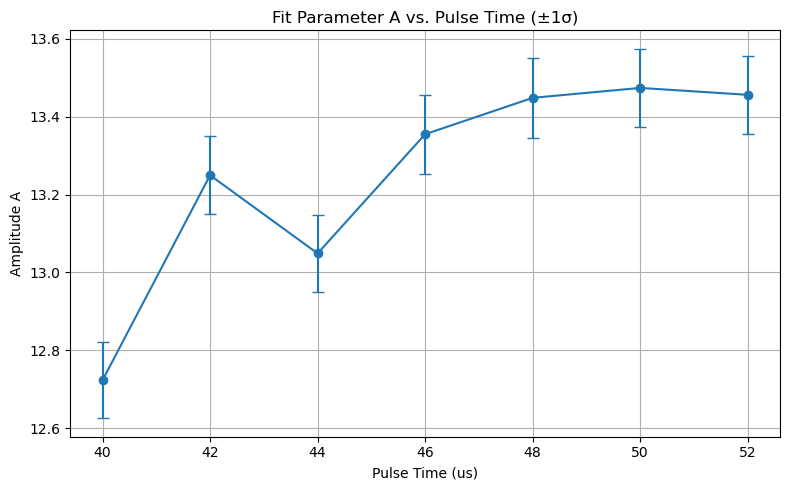

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt

# Define the complex exponential model with frequency.
def model_complex(t, A, T2star, f, phi, C_real, C_imag):
    """
    Returns the complex signal:
      A * exp(-t/T2star) * exp(i*(2*pi*f*t + phi)) + (C_real + i*C_imag)
    """
    return A * np.exp(-t / T2star) * np.exp(1j * (2 * np.pi * f * t + phi)) + (C_real + 1j * C_imag)

def model_complex_stacked(t, A, T2star, f, phi, C_real, C_imag):
    """
    Returns a stacked 1D array of real and imaginary parts.
    This stacking is needed because curve_fit works with real-valued functions.
    """
    model_vals = model_complex(t, A, T2star, f, phi, C_real, C_imag)
    return np.concatenate((model_vals.real, model_vals.imag))

# Group the data by pulse time.
grouped_data = defaultdict(list)
for df, pulse_time in zip(data, pulse_times):
    grouped_data[pulse_time].append(df)

# List to store the averaged data, fit results, and errors for each pulse time.
all_fits = []

# Process each group (pulse time).
for pulse_time, dfs in sorted(grouped_data.items()):
    signals = []   # list to store the complex signals from each trace
    t_common = None
    for df in dfs:
        t = df['t'].values
        if t_common is None:
            t_common = t  # assume time arrays are the same for a given pulse time

        # Create the complex signal from the two channels.
        signal = df['CH1'].values + 1j * df['CH2'].values

        # Smooth the signal using a lowpass Butterworth filter.
        b, a = butter(3, 5000, btype="lowpass", fs=500000)
        signal = filtfilt(b, a, signal)
        signals.append(signal)
    
    # Convert to numpy array: shape (n_traces, n_points)
    signals = np.array(signals)
    
    # Compute the average and standard deviation separately for real and imaginary parts.
    avg_real = np.mean(np.real(signals), axis=0)
    avg_imag = np.mean(np.imag(signals), axis=0)
    std_real = np.std(np.real(signals), axis=0, ddof=1) if signals.shape[0] > 1 else np.zeros_like(avg_real)
    std_imag = np.std(np.imag(signals), axis=0, ddof=1) if signals.shape[0] > 1 else np.zeros_like(avg_imag)
    
    # Reconstruct the averaged complex signal.
    avg_signal = avg_real + 1j * avg_imag

    # Prepare ydata for fitting (stacked real and imaginary parts).
    ydata = np.concatenate((avg_signal.real, avg_signal.imag))
    
    # Initial guess for parameters:
    # A: amplitude from the first point's magnitude.
    # T2: a guess (e.g., 0.001 s).
    # f: initial guess for frequency.
    # phi: phase from the first data point.
    # C_real and C_imag: zero offset.
    p0 = [10,
          0.001,
          2000,  # frequency initial guess (Hz)
          np.angle(avg_signal[0]),
          0,
          0]
    
    try:
        popt, pcov = curve_fit(model_complex_stacked, t_common, ydata, p0=p0)
        # Print covariance matrix with 3 digits in scientific notation.
        print(f"Covariance matrix for pulse time {pulse_time}:")
        print("Fit parameter names: A, T2star, f, phi, C_real, C_imag")
        print(np.array2string(pcov, formatter={'float_kind': lambda x: f'{x:.3e}'}))
        # Calulate correlation coefficients.
        corr_coeffs = np.corrcoef(pcov)
        print("Correlation coefficients:")
        print(np.array2string(corr_coeffs, formatter={'float_kind': lambda x: f'{x:.3e}'}))
        # Extract standard deviations for the fitted parameters from the covariance matrix.
        perr = np.sqrt(np.diag(pcov))
        fit_success = True
    except RuntimeError:
        popt = [np.nan] * 6
        perr = [np.nan] * 6
        fit_success = False
    
    # Evaluate the fitted model on the common time array.
    fitted_curve = model_complex(t_common, *popt)
    
    # Save the averaged data and fit results.
    all_fits.append({
        'pulse_time': pulse_time,
        't': t_common,
        'avg_real': avg_real,
        'avg_imag': avg_imag,
        'std_real': std_real,
        'std_imag': std_imag,
        'fit_real': fitted_curve.real,
        'fit_imag': fitted_curve.imag,
        'popt': popt,
        'perr': perr,
        'fit_success': fit_success
    })

# Create subplots: one row per pulse time, two columns (real and imaginary).
num_fits = len(all_fits)
fig, axs = plt.subplots(nrows=num_fits, ncols=2, figsize=(12, 3*num_fits), sharex=True)
if num_fits == 1:
    axs = np.array([axs])

for i, fit in enumerate(all_fits):
    DOWNSAMPLE_RATE = 25
    # Left subplot: Real part with error bars.
    axs[i, 0].errorbar(fit['t'][::DOWNSAMPLE_RATE], fit['avg_real'][::DOWNSAMPLE_RATE],
                        yerr=fit['std_real'][::DOWNSAMPLE_RATE], fmt='o', alpha=0.6, label='Data Real')
    if fit['fit_success']:
        axs[i, 0].plot(fit['t'], fit['fit_real'], '-', alpha=0.6, label='Fit Real')
    else:
        axs[i, 0].text(0.05, 0.9, 'Fit Failed', transform=axs[i, 0].transAxes, color='red')
    axs[i, 0].set_ylabel('Real Part')
    axs[i, 0].set_title(f'Pulse {fit["pulse_time"]} (Real)')
    axs[i, 0].legend(fontsize='small')
    axs[i, 0].grid(True)
    
    # Right subplot: Imaginary part with error bars.
    axs[i, 1].errorbar(fit['t'][::DOWNSAMPLE_RATE], fit['avg_imag'][::DOWNSAMPLE_RATE],
                        yerr=fit['std_imag'][::DOWNSAMPLE_RATE], fmt='o', alpha=0.6, label='Data Imag')
    if fit['fit_success']:
        axs[i, 1].plot(fit['t'], fit['fit_imag'], '-', alpha=0.6, label='Fit Imag')
    else:
        axs[i, 1].text(0.05, 0.9, 'Fit Failed', transform=axs[i, 1].transAxes, color='red')
    axs[i, 1].set_ylabel('Imaginary Part')
    axs[i, 1].set_title(f'Pulse {fit["pulse_time"]} (Imaginary)')
    axs[i, 1].legend(fontsize='small')
    axs[i, 1].grid(True)

# Label the x-axis on the bottom subplots.
for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Build a summary DataFrame for the amplitude A from each pulse time group.
results_list = []
for fit in all_fits:
    if fit['fit_success']:
        A = fit['popt'][0]
        A_err = fit['perr'][0]
        results_list.append({'Pulse Time (us)': fit['pulse_time'], 'A': A, 'A_err': A_err})
results_df = pd.DataFrame(results_list).sort_values('Pulse Time (us)')

# Plot A vs. Pulse Time with error bars from the covariance matrix.
plt.figure(figsize=(8, 5))
plt.errorbar(results_df['Pulse Time (us)'], results_df['A'],
             yerr=results_df['A_err'], fmt='o-', capsize=4)
plt.xlabel('Pulse Time (us)')
plt.ylabel('Amplitude A')
plt.title('Fit Parameter A vs. Pulse Time (±1σ)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use Hilbert transform to reconstruct envelope, then fit to decaying exponential (NOTE: doesn't work well)

In [6]:
PAD_SIZE = 1000
def fit_decay_with_envelope(df, channel='CH1', prominence=0.2, min_distance=100):
    t = df['t'].values
    signal_raw = df[channel].values
    
    # Compute the analytic signal using the Hilbert transform
    signal_padded = np.pad(signal_raw, (PAD_SIZE, PAD_SIZE), mode="reflect")
    signal_padded = gaussian_filter1d(signal_padded, sigma=10)  # Smoothing to suppress small oscillations
    analytic_signal_padded = hilbert(signal_padded)
    analytic_signal = analytic_signal_padded[PAD_SIZE:-PAD_SIZE]  # Remove padding
    envelope = np.abs(analytic_signal)  # Extract the envelope (magnitude of analytic signal)
    envelope = gaussian_filter1d(envelope, sigma=10)  # Smoothing to suppress small oscillations
    
    # Initial guess for parameters A, T2*, and C (use the first value of the envelope as A, and its decay time)
    p0 = [envelope[0], (t.max() - t.min()) / 2.0, np.min(envelope)]
    popt, _ = curve_fit(model_exp, t, envelope, p0=p0)

    return popt, envelope

    Dataset  Pulse Time (us)  Real_T2star  Imag_T2star
0         1               42     0.002312     0.000890
1         2               40     0.002714     0.000896
2         3               44     0.002719     0.000961
3         4               40     0.002742     0.000873
4         5               42     0.002926     0.000912
5         6               42     0.002467     0.000914
6         7               40     0.002842     0.000911
7         8               46     0.002388     0.000942
8         9               40     0.002842     0.000911
9        10               42     0.002853     0.000904
10       11               46     0.002255     0.000964
11       12               44     0.002831     0.000977
12       13               44     0.002661     0.000910
13       14               46     0.002740     0.000973
14       15               42     0.002758     0.000888
15       16               40     0.002638     0.000889
16       17               46     0.002691     0.000936
17       1

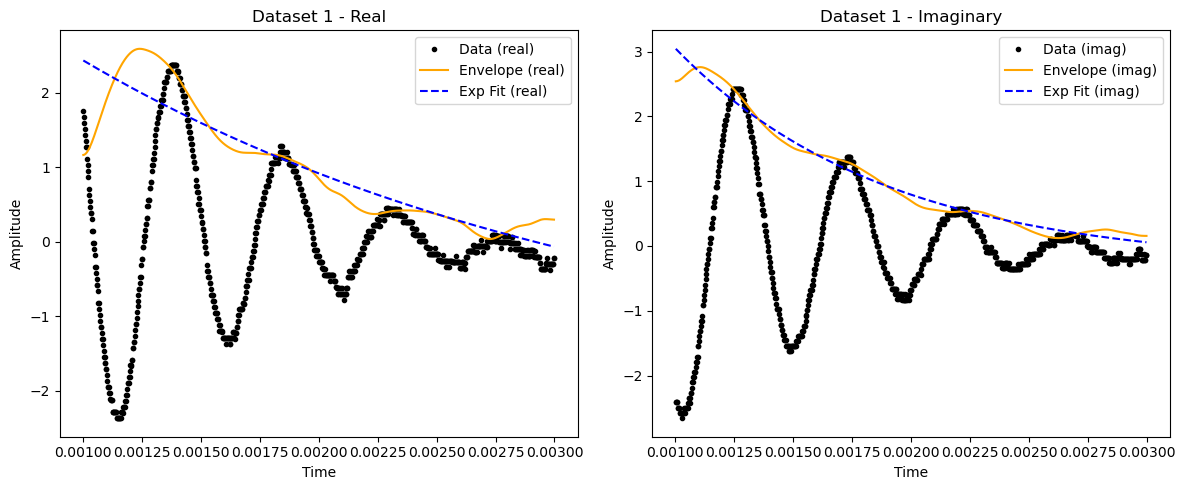

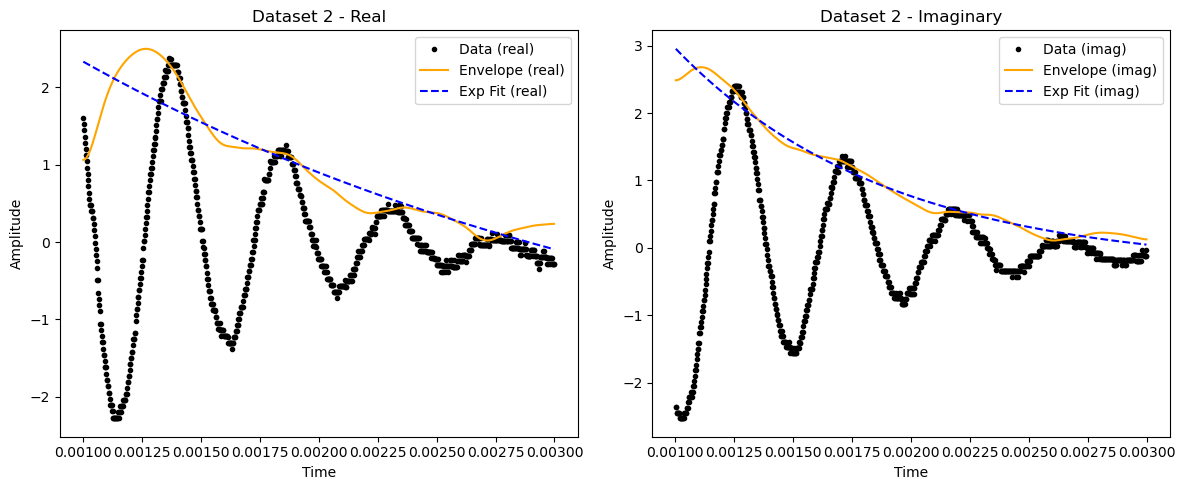

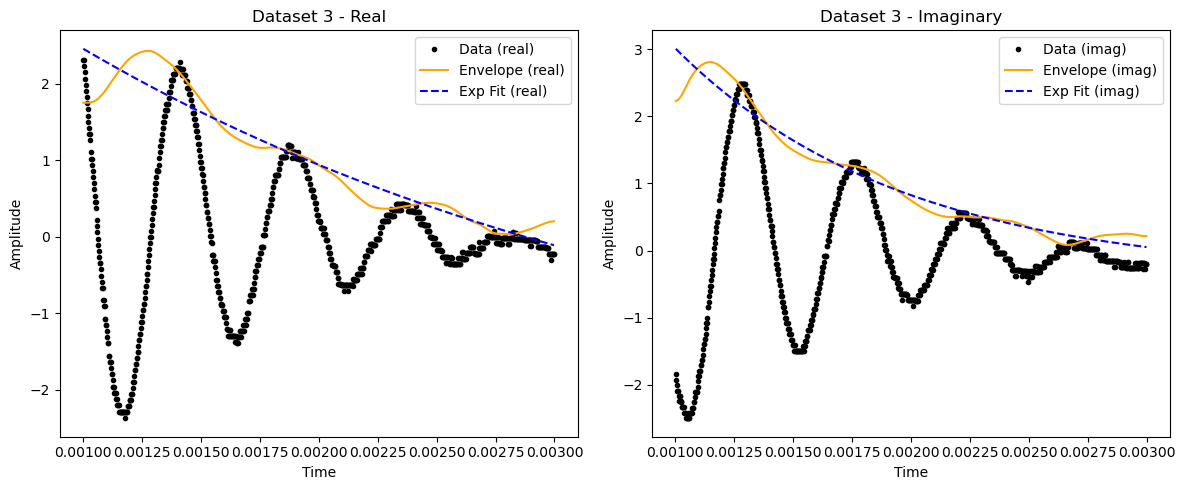

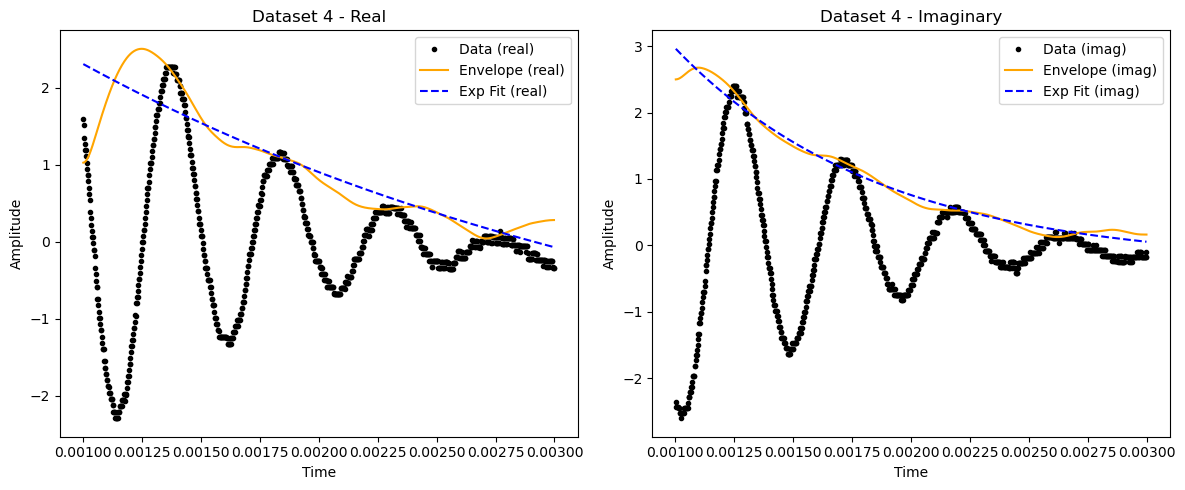

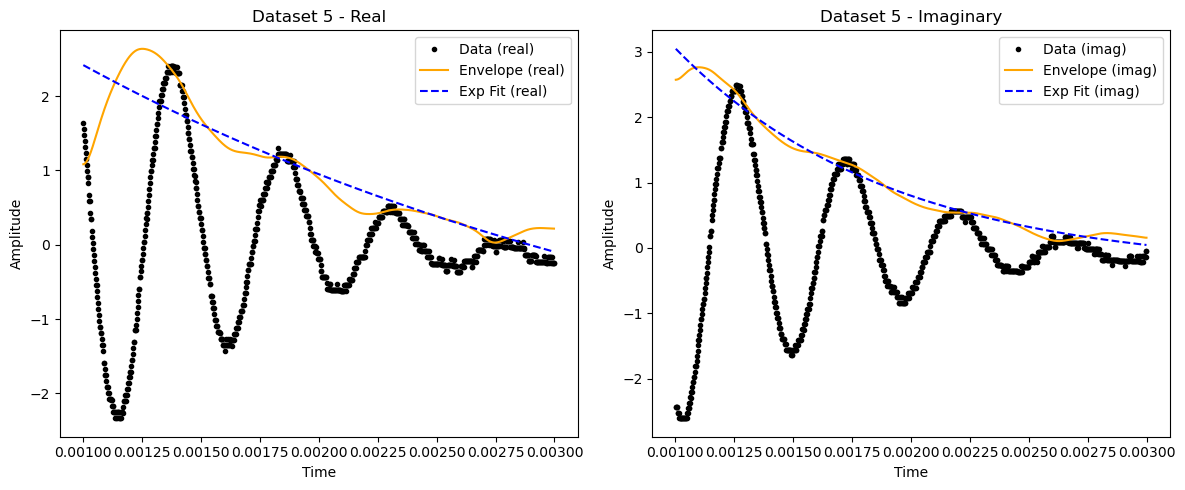

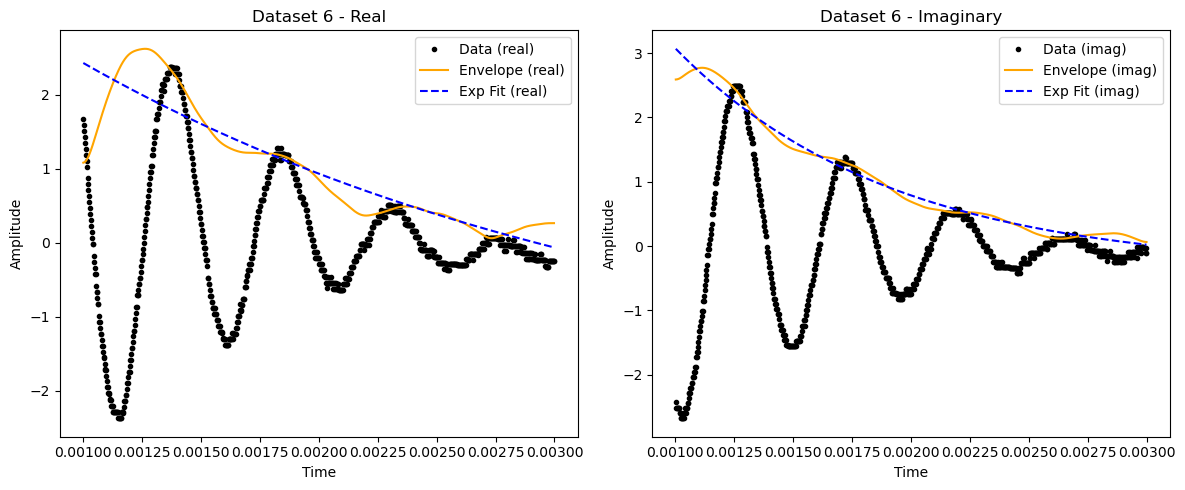

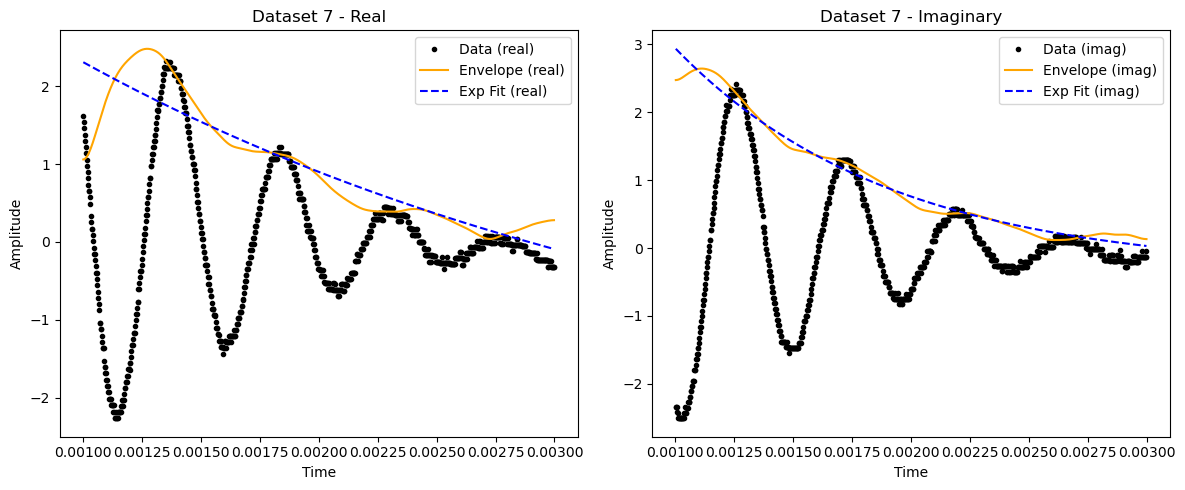

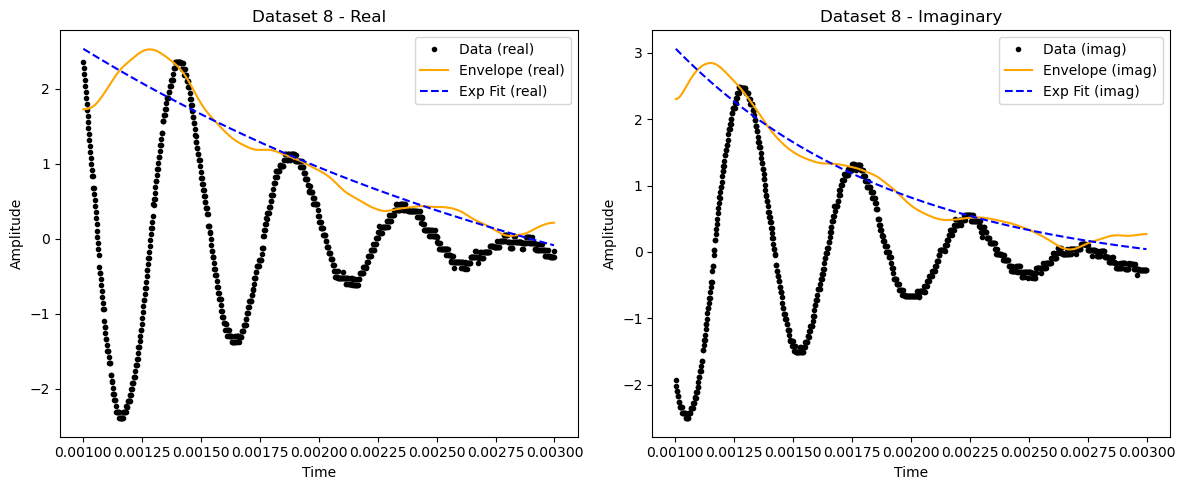

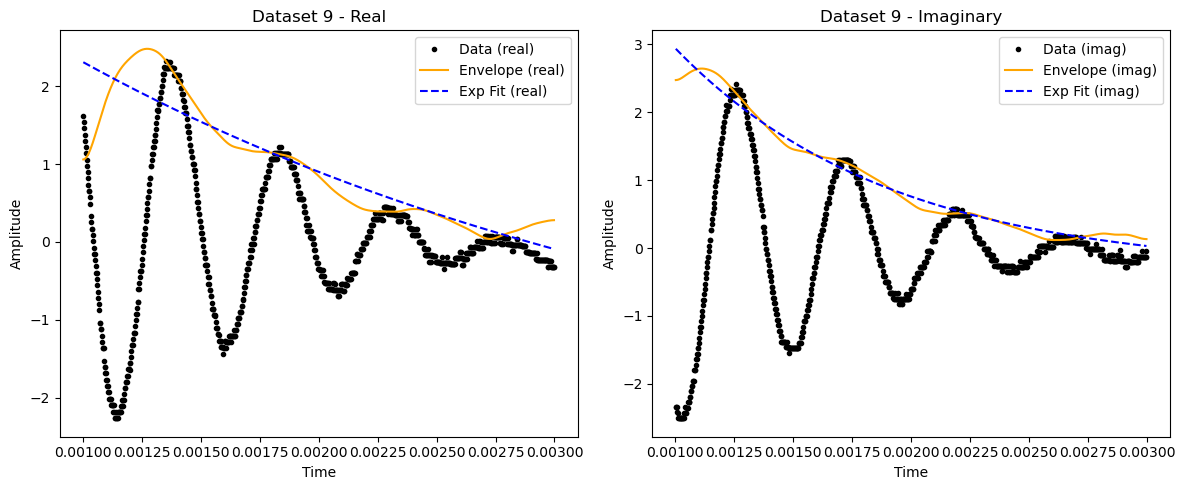

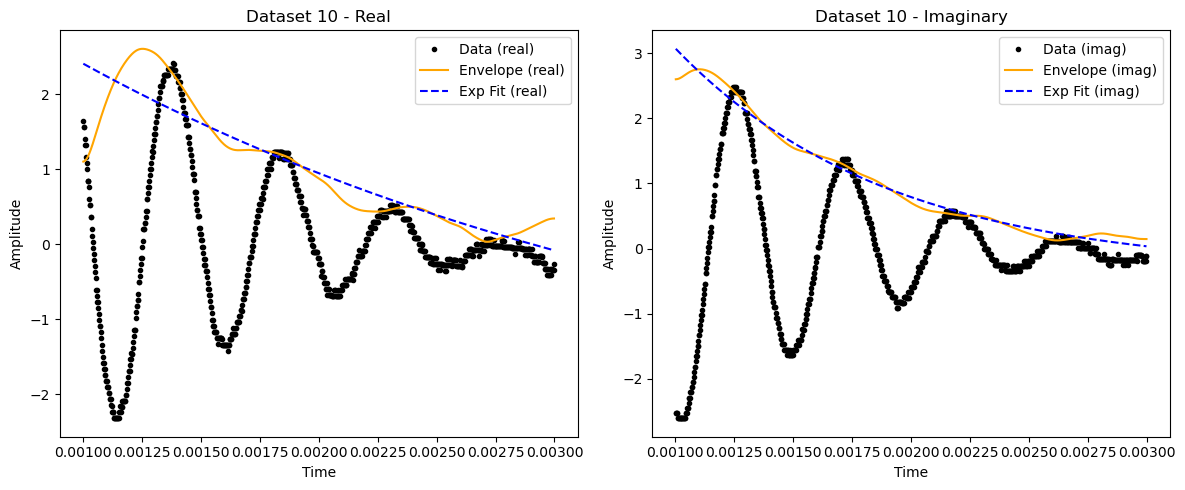

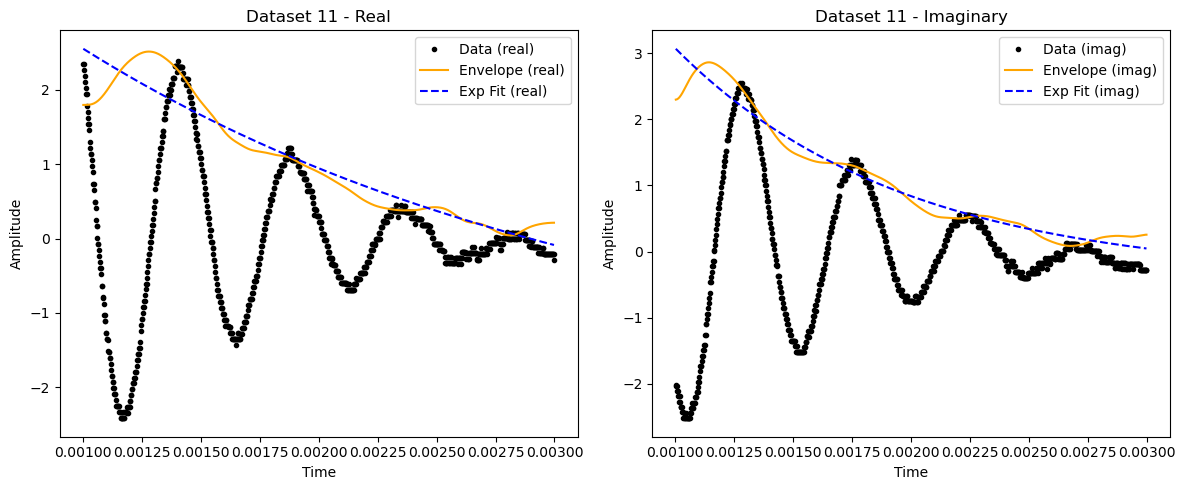

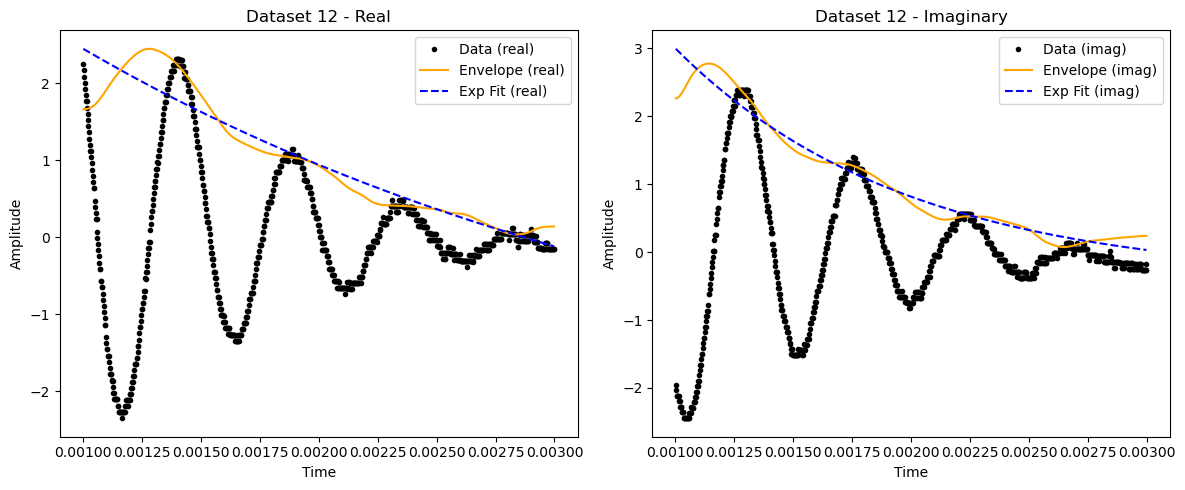

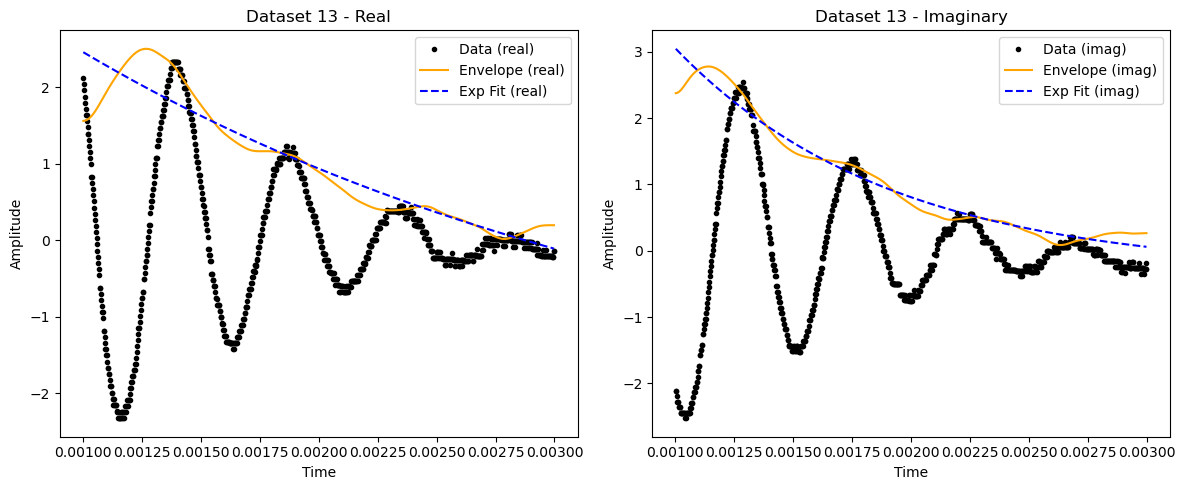

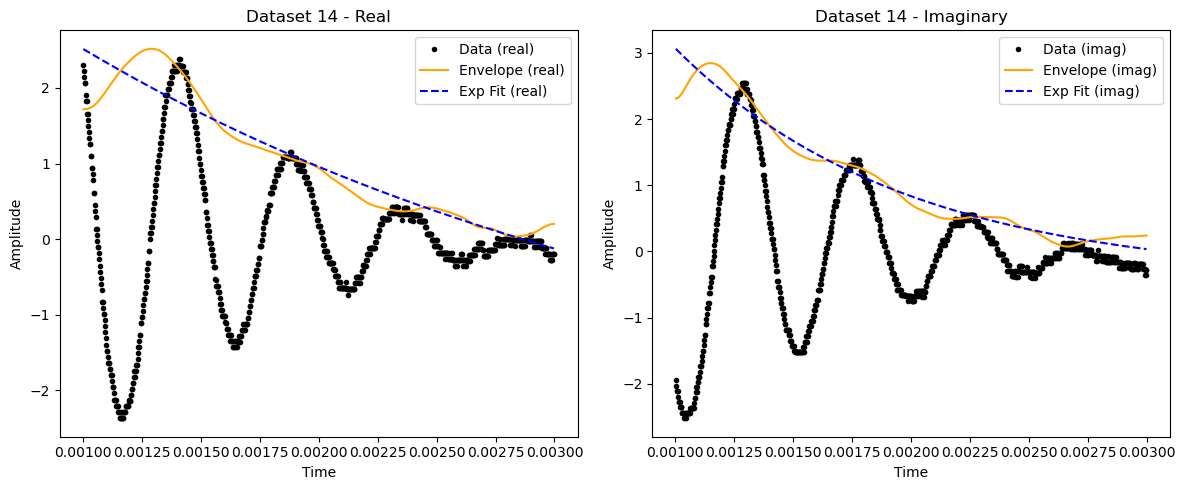

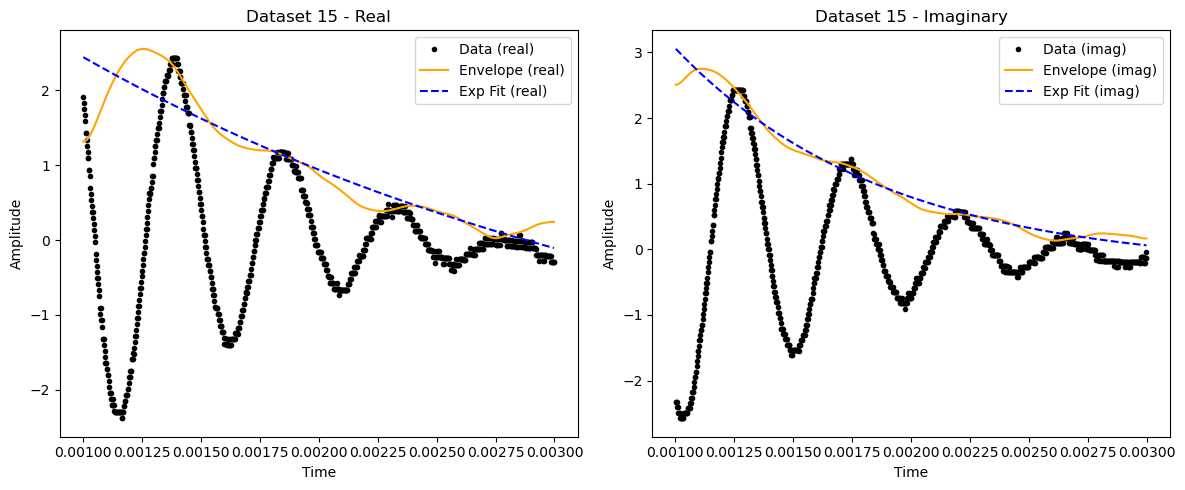

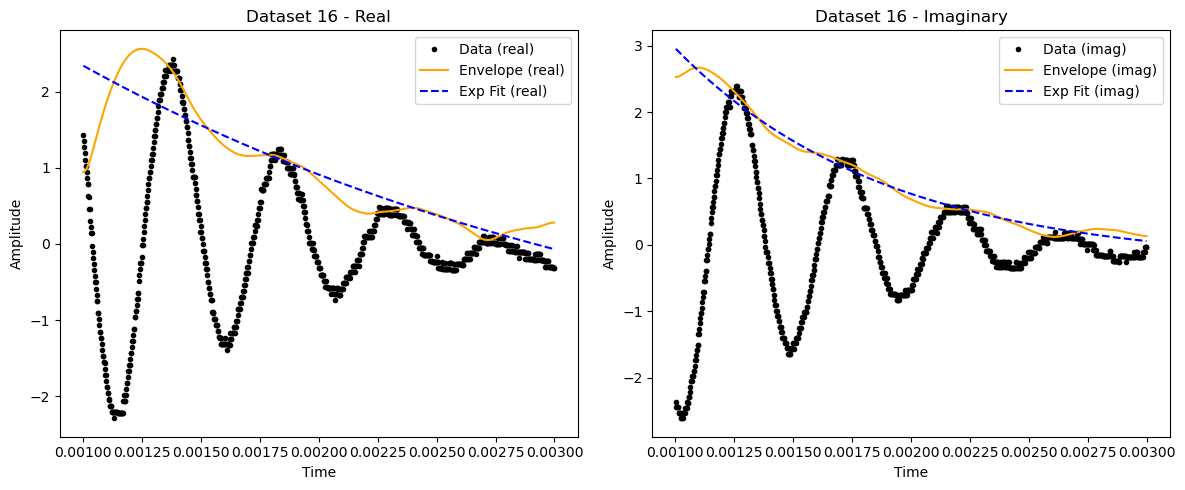

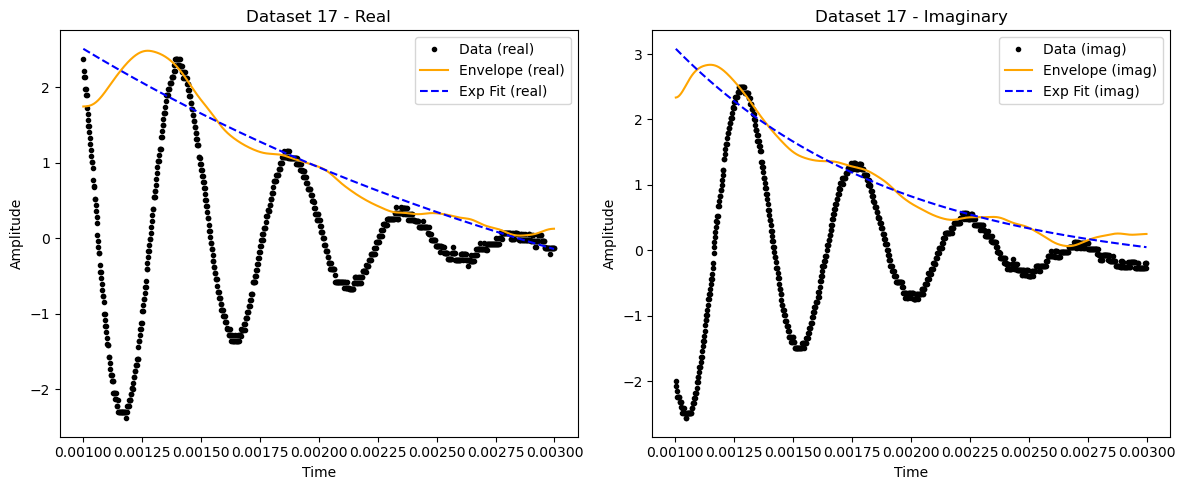

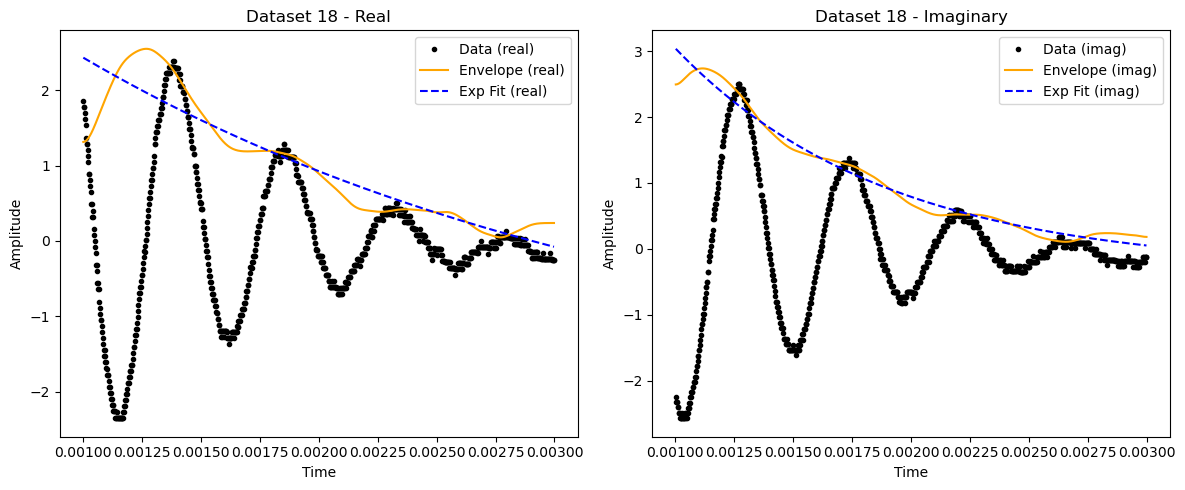

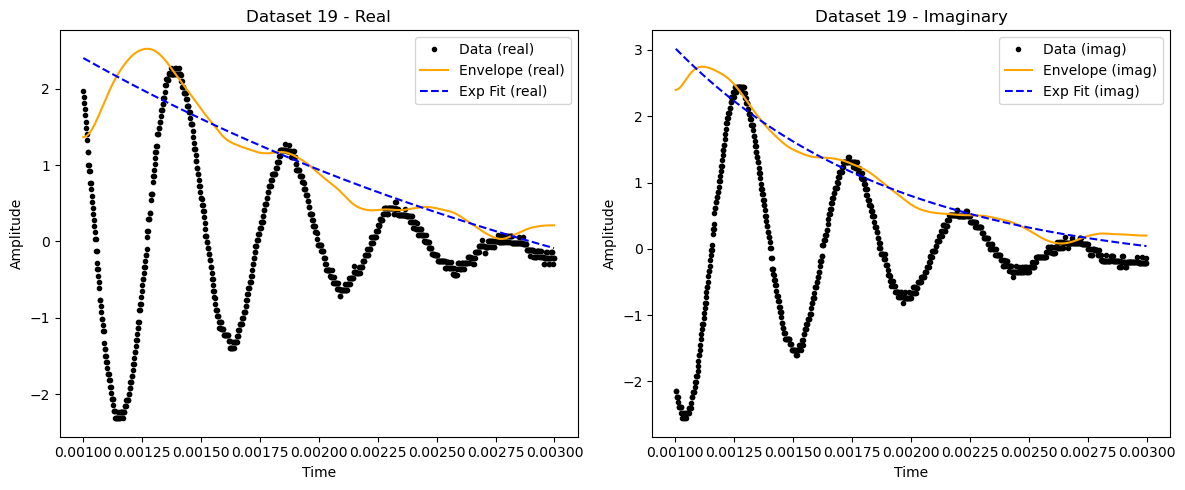

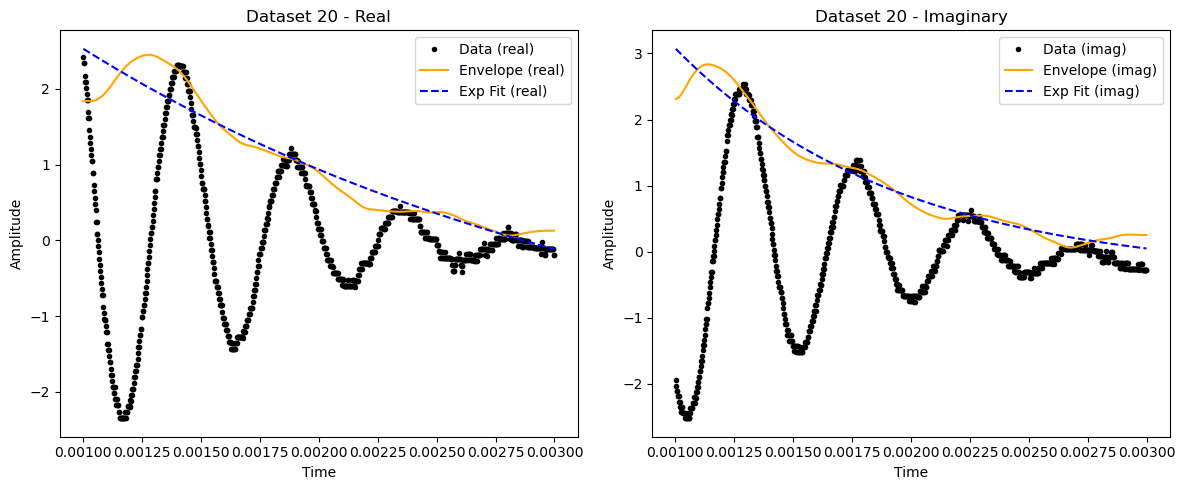

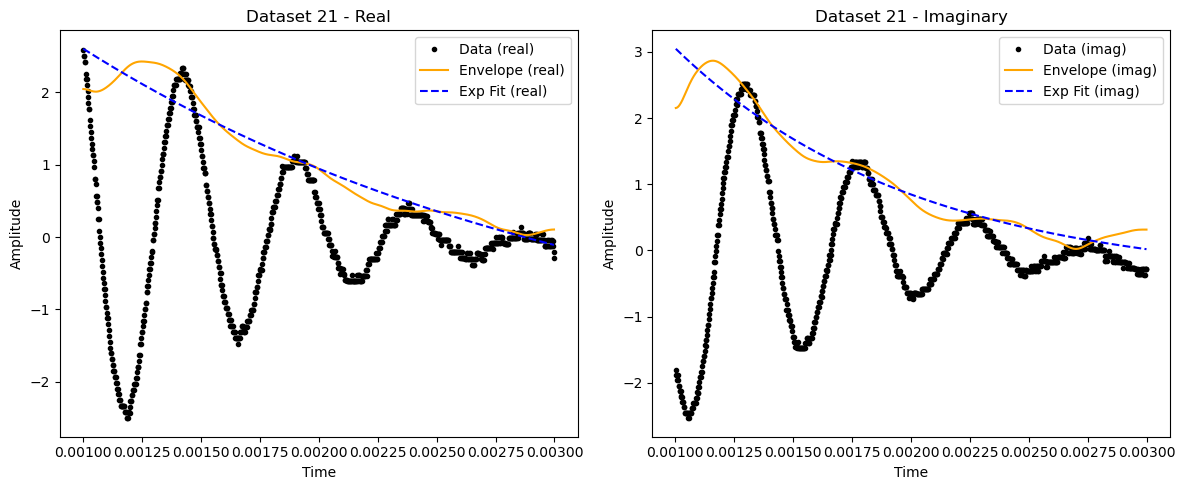

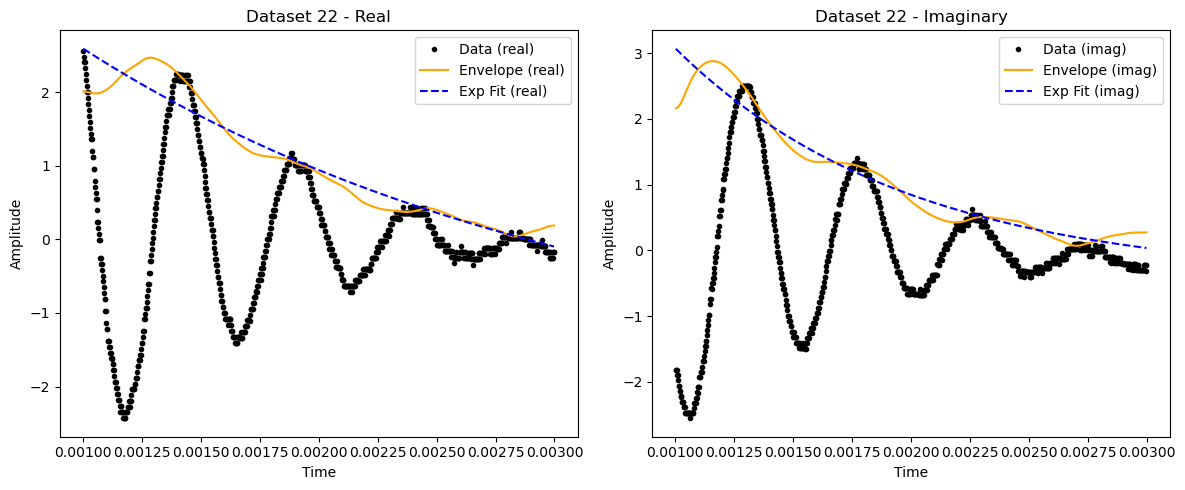

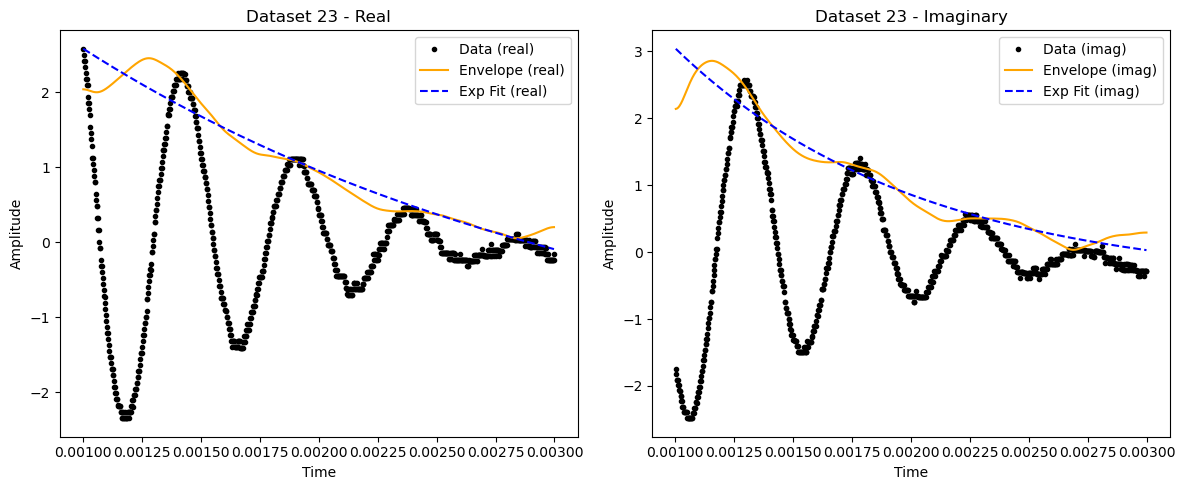

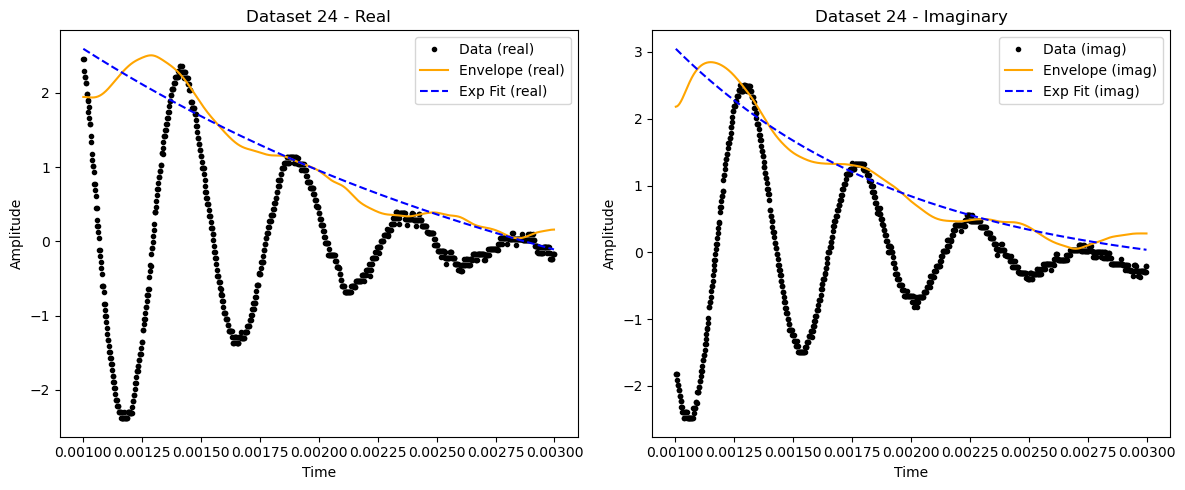

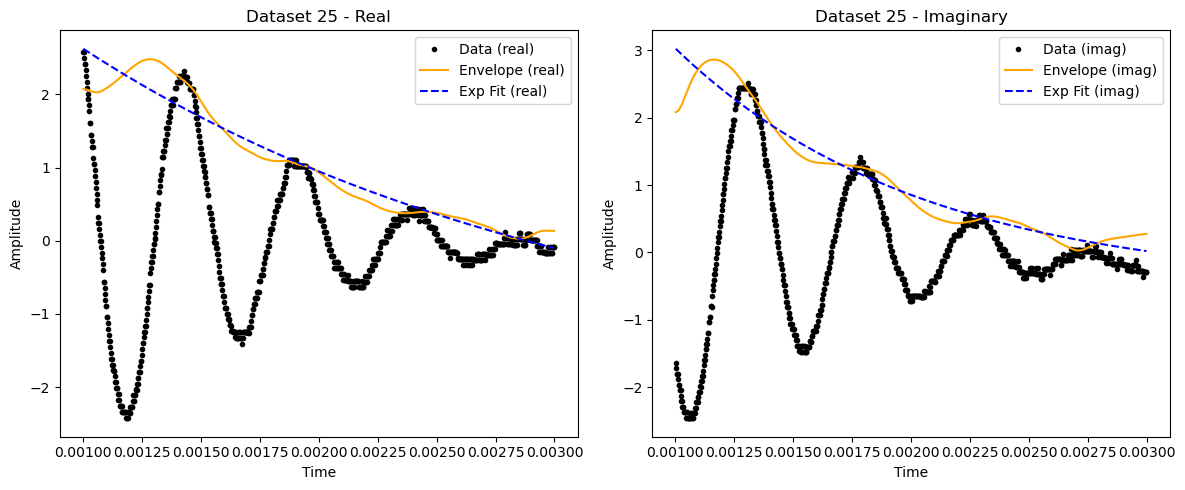

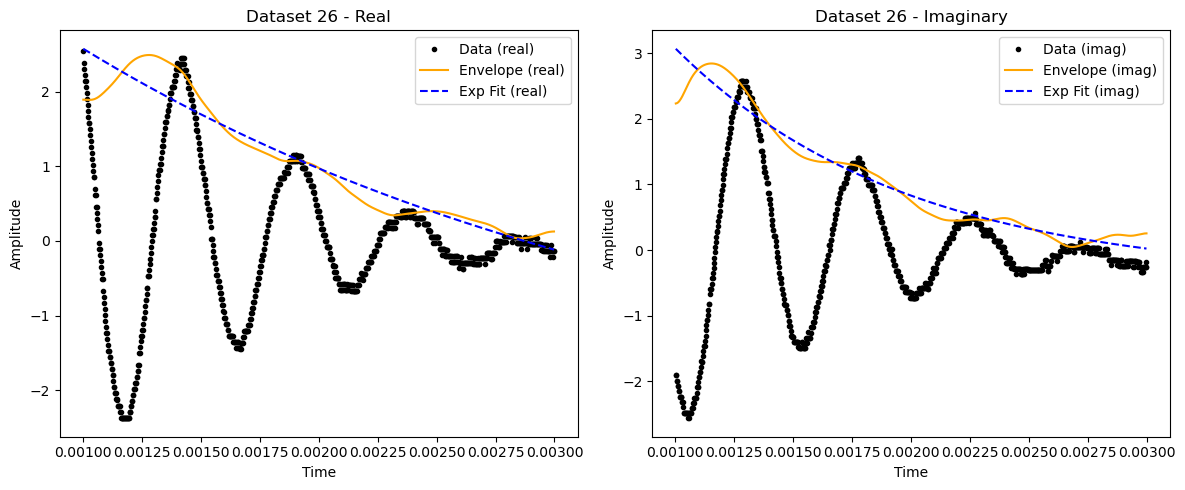

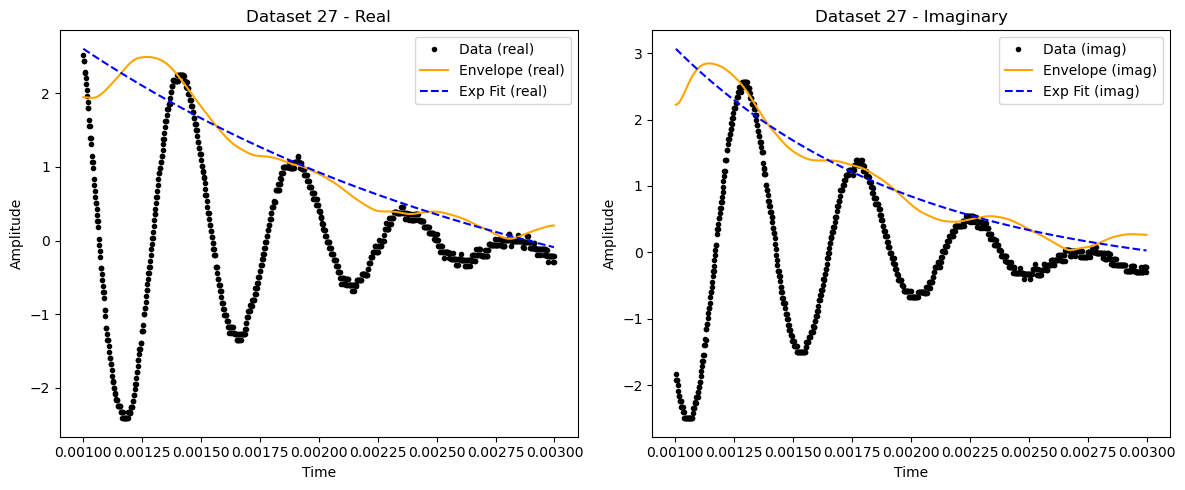

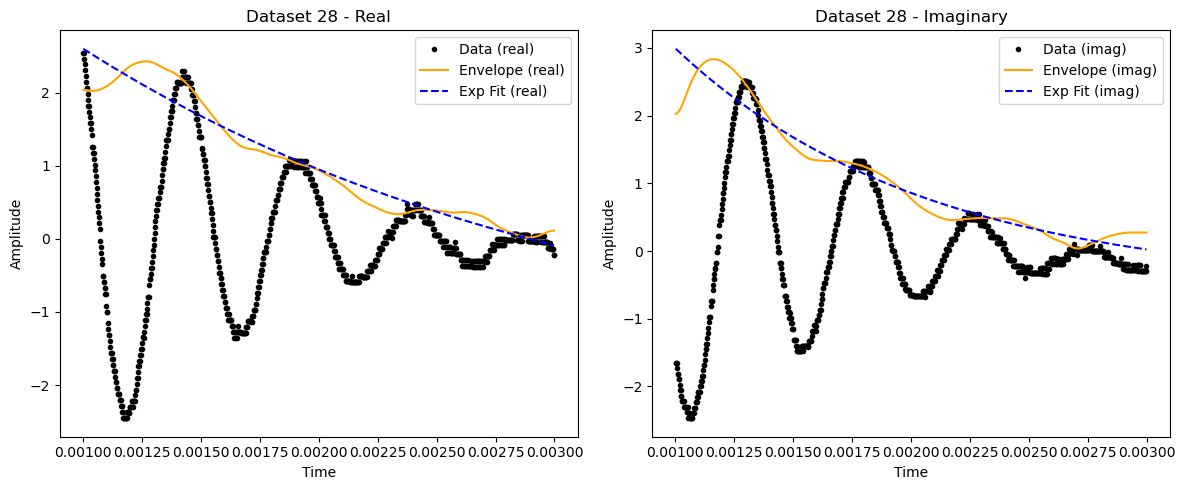

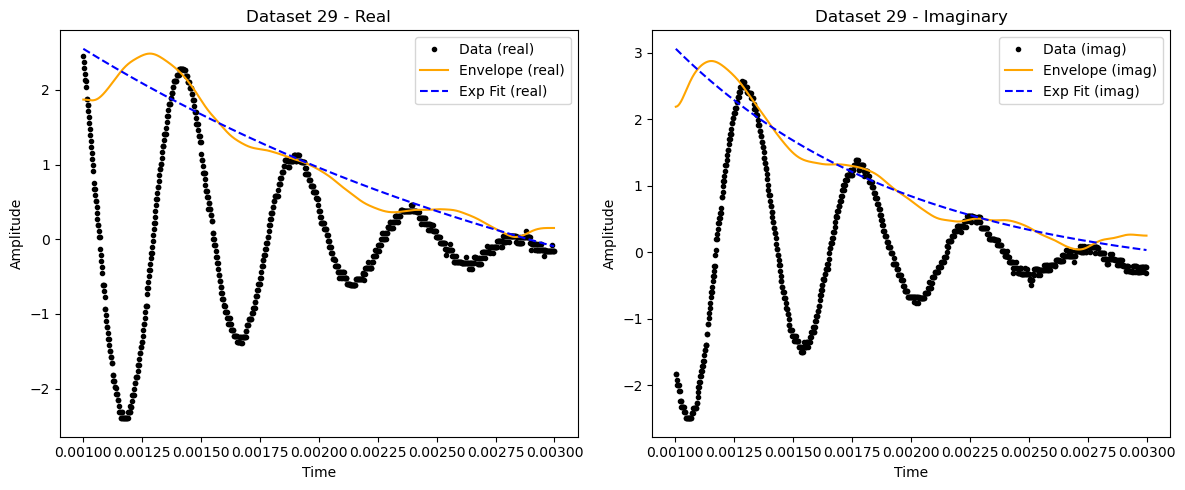

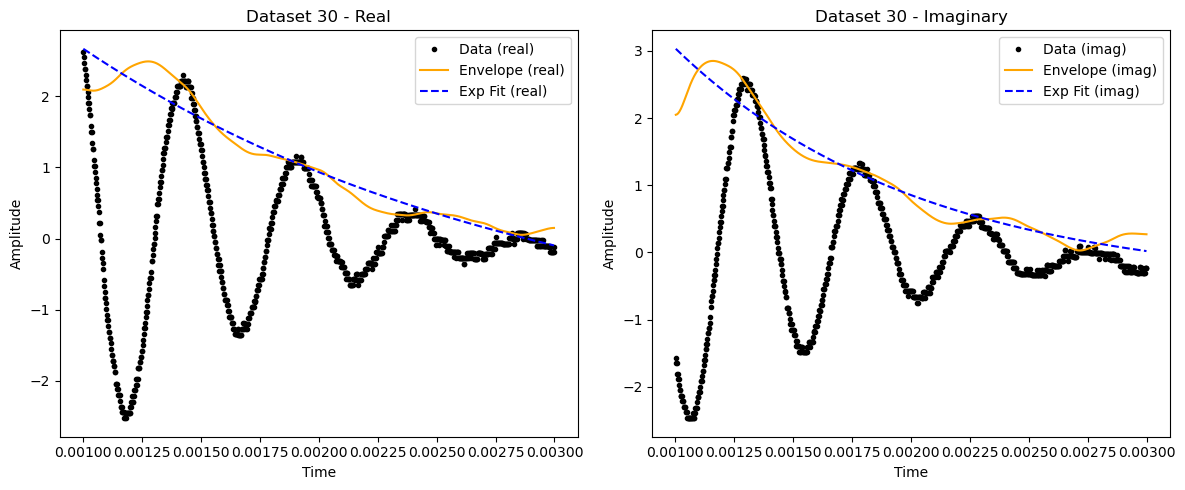

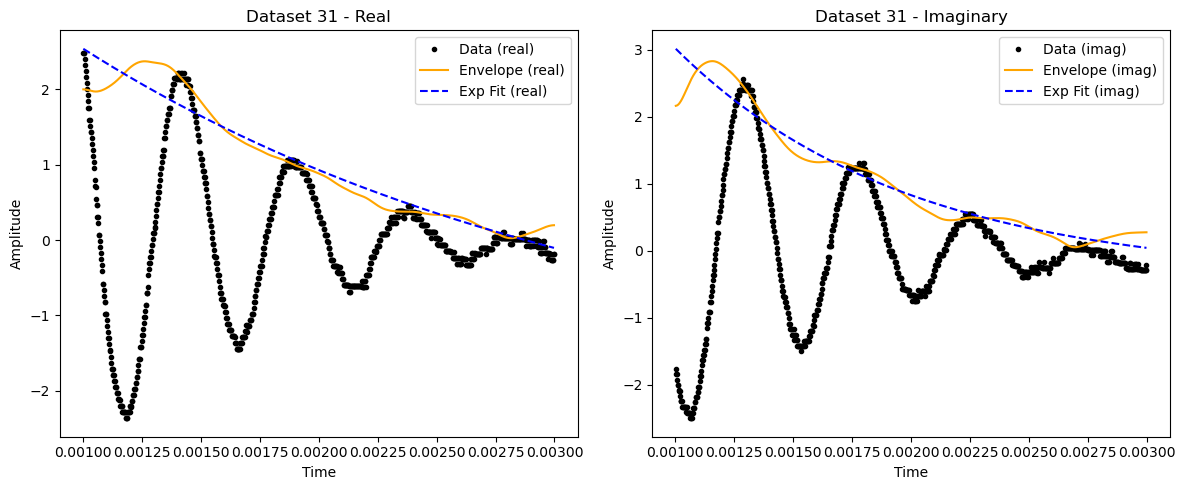

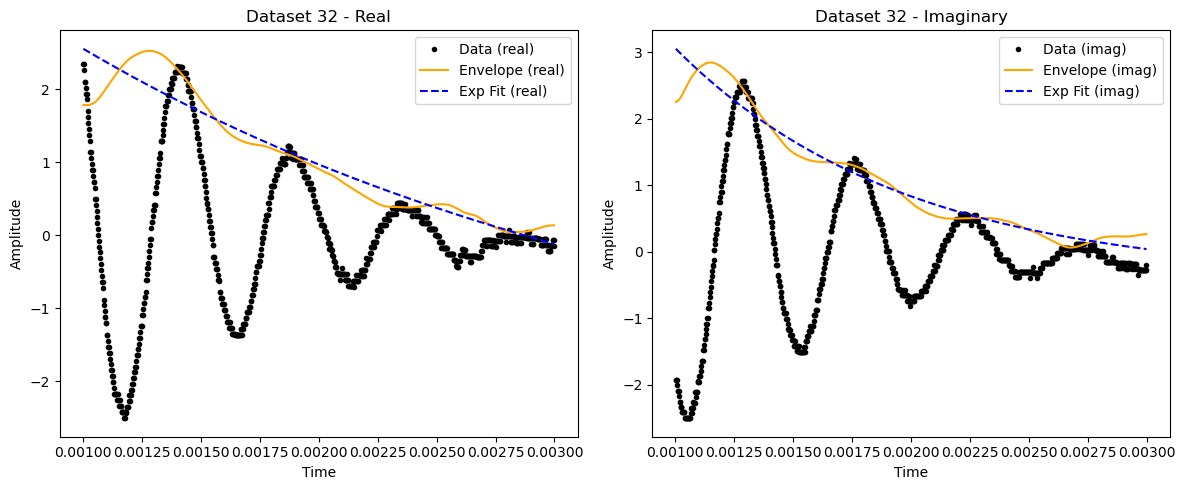

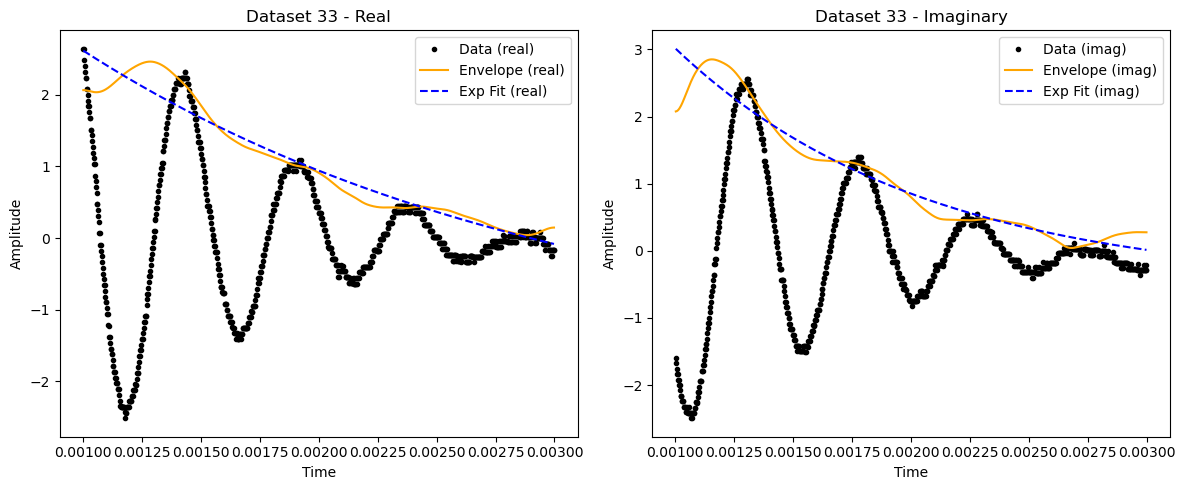

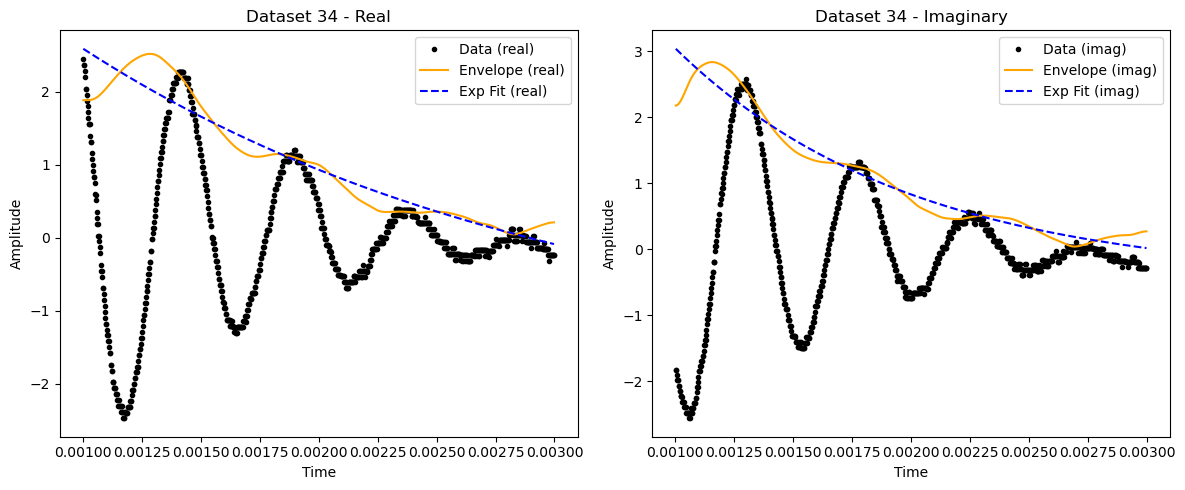

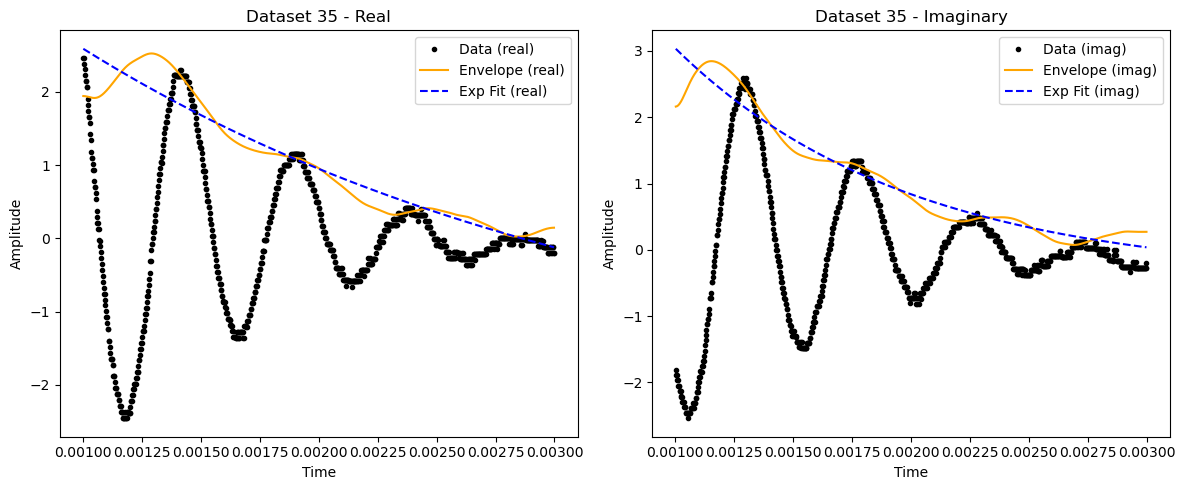

Real T2*:
  Mean T2* = 0.0025 us
  Std = 0.0003
  SEM = 0.0000
  95% CI = ±0.0001

Imaginary T2*:
  Mean T2* = 0.0010 us
  Std = 0.0001
  SEM = 0.0000
  95% CI = ±0.0000



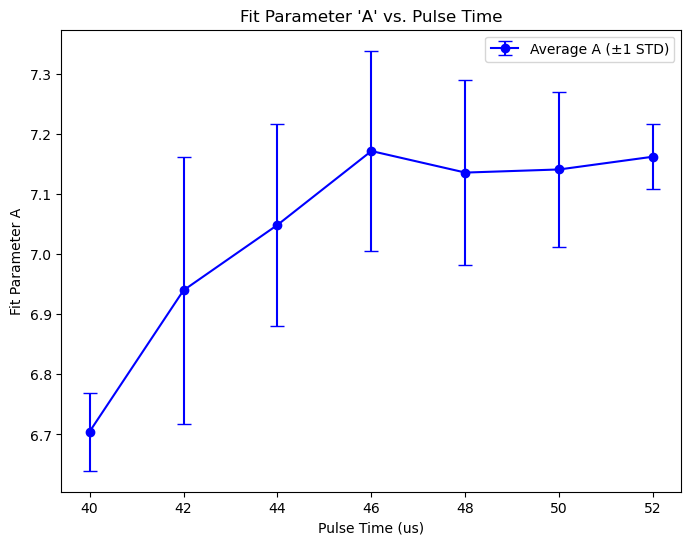

In [7]:
results = []
fits = []

TIME_CUTOFF = 0.003  # 3 ms cutoff for the time axis

# Loop through each dataset
for idx, (df, pulse_time) in enumerate(zip(data, pulse_times)):
    df = df[df['t'] < TIME_CUTOFF]  # Apply time cutoff

    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # Subtract linear fit
    real_signal -= np.polyval(np.polyfit(t, real_signal, 1), t)
    imag_signal -= np.polyval(np.polyfit(t, imag_signal, 1), t)

    # Apply the robust envelope fitting to both real and imaginary channels
    popt_real, env_real = fit_decay_with_envelope(df, channel='CH1')
    popt_imag, env_imag = fit_decay_with_envelope(df, channel='CH2')
    
    # Store results (e.g., the T2* from the exponential fit)
    results.append({
        'Dataset': idx + 1,
        'Pulse Time (us)': pulse_time,
        'Real_T2star': popt_real[1],
        'Imag_T2star': popt_imag[1]
    })

    fits.append((t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag))

# Display summary results
results_df = pd.DataFrame(results)
print(results_df)

# ------------------
# PLOTTING THE FITS FOR EACH DATASET
# ------------------
# Plot the results
for idx, (t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag) in enumerate(fits):
    # Plot Real Channel (CH1)
    plt.figure(figsize=(12, 5))

    # Real part
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'k.', label='Data (real)')
    plt.plot(t, env_real, 'orange', label='Envelope (real)')
    plt.plot(t, model_exp(t, *popt_real), 'b--', label='Exp Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()

    # Imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'k.', label='Data (imag)')
    plt.plot(t, env_imag, 'orange', label='Envelope (imag)')
    plt.plot(t, model_exp(t, *popt_imag), 'b--', label='Exp Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Imaginary')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display summary statistics for T2* (Real and Imaginary)
def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2* = {mean:.4f} us\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

# Summary for Real (CH1) and Imaginary (CH2) T2* values
real_t2star = pd.Series([popt_real[1] for _, _, _, _, _, popt_real, _ in fits])
imag_t2star = pd.Series([popt_imag[1] for _, _, _, _, _, _, popt_imag in fits])

summarize(real_t2star, "Real T2*")
summarize(imag_t2star, "Imaginary T2*")

# ------------------
# PLOTTING THE 'A' FIT PARAMETER VS. PULSE TIME
# ------------------
# Here we use the 'A' parameter from the real-part fit as the scale.
pulse_A = [popt_real[0] for (_, _, _, _, _, popt_real, _) in fits]
df_A = pd.DataFrame({'Pulse Time (us)': pulse_times, 'A': pulse_A})
grouped_A = df_A.groupby('Pulse Time (us)')['A'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(grouped_A['Pulse Time (us)'], grouped_A['mean'], yerr=grouped_A['std'],
             fmt='bo-', capsize=5, label="Average A (±1 STD)")
plt.xlabel('Pulse Time (us)')
plt.ylabel('Fit Parameter A')
plt.title("Fit Parameter 'A' vs. Pulse Time")
plt.legend()
plt.show()